# Visualizing Intermediate Representations in CNN

To get a feel for what kind of features the covolutional neural network has learned, one thing to do is to visualize how an input image gets transformed as it goes through the CNN.

In this notebook, we will use a CNN which has been pre-trained for cat-dog classification task.

Given an input image, we will display the output of each convolutional and pooling layer of the CNN.

We can also visualize what the hidden units in different layers are computing by finding the images that maximize the unit's activation.

In [1]:
%matplotlib inline
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import random
from tensorflow.keras.models import load_model, Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

Using TensorFlow backend.


## 1. Load Model
We will use a pre-trained CNN model (for cat-dog classification) in this notebook. The input dimension is (150, 150).

In [2]:
# load the model

model = load_model('my_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [3]:
model.metrics_names

['loss', 'acc']

To verify that the model has been trained properly, we evaluate the model on the original training data.

In [4]:
# create image data

# training set
train_gen = ImageDataGenerator(rescale = 1/255) 
train_generator = train_gen.flow_from_directory(
        'data/train/',  
        target_size = (150, 150), 
        batch_size = 20,
        class_mode = 'binary')

# print class indices
print("Class index: "  + str(train_generator.class_indices))

Found 2000 images belonging to 2 classes.
Class index: {'cats': 0, 'dogs': 1}


In [5]:
metrics = model.evaluate_generator(train_generator, verbose = 0)
print('Training Accuracy: ' + str(metrics[1]))

Training Accuracy: 0.8785


## 2. Visualizing Intermediate Representations

We randomly pick an image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map.

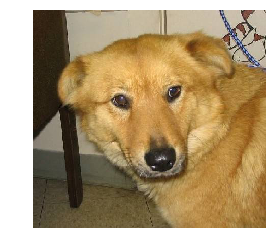

In [6]:
# Define a new model that will take an image as input, and will output intermediate representations for all layers in 
# the previous model
outputs = [layer.output for layer in model.layers]
vis_model = Model(inputs = model.input, outputs = outputs)

# Get a random input image from the training set.
random.seed(35)
train_cat_dir = os.path.join('data/train/cats')
train_dog_dir = os.path.join('data/train/dogs')
train_cat_names = os.listdir(train_cat_dir)
train_dog_names = os.listdir(train_dog_dir)
train_cat_paths = [os.path.join(train_cat_dir, fname) for fname in train_cat_names]
train_dog_paths = [os.path.join(train_dog_dir, fname) for fname in train_dog_names]
img_path = random.choice(train_cat_paths + train_dog_paths)
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')

img = image.load_img(img_path, target_size = (150, 150))  # this is a PIL image
x = image.img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
x /= 255

# Let's run our image through our network, thus obtaining all intermediate representations for this image.
feature_maps = vis_model.predict(x)

# Get the names of the layers
layer_names = [layer.name for layer in model.layers]

C:\Users\Sandy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


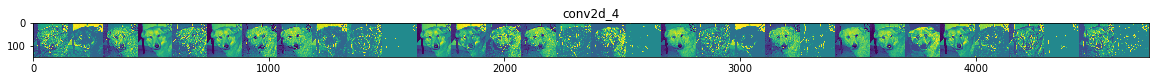

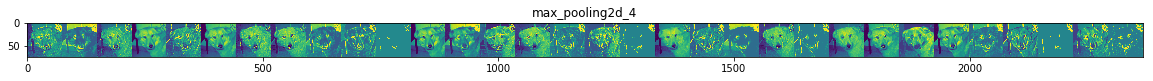

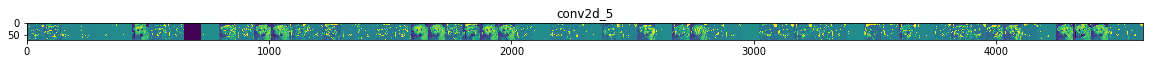

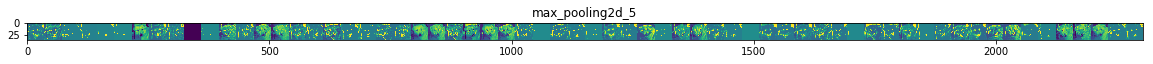

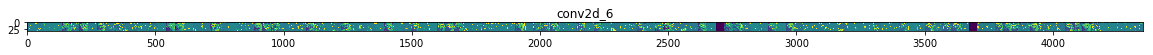

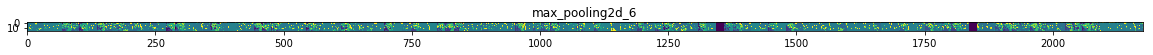

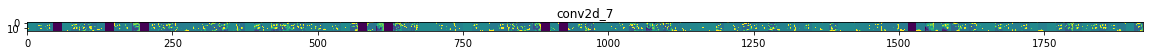

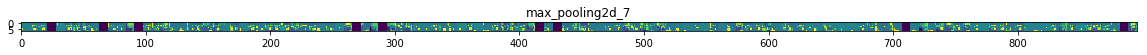

In [7]:
# Now let's display our representations

for layer_name, feature_map in zip(layer_names, feature_maps):
    # Only for the conv / pooling layers, not the fully-connected layers
    if len(feature_map.shape) == 4:
            n_channels = feature_map.shape[-1]  # number of channels in current feature map
            # The feature map has shape (1, size, size, n_channels)
            size = feature_map.shape[1]
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_channels))
            # Postprocess the feature to make it visually palatable
            for i in range(n_channels):
                    x = feature_map[0, :, :, i]
                    x -= x.mean()
                    x /= x.std()
                    x *= 64
                    x += 128
                    x = np.clip(x, 0, 255).astype('uint8')
                    # We'll tile each filter into this big horizontal grid
                    display_grid[:, i * size : (i + 1) * size] = x
            # Display the grid
            height = 20. / n_channels # figure height
            plt.figure(figsize = (height * n_channels, height)) # each small figure has the same height and width 
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

It is hard to see the pictures of a layer when the number of channels is too large. In the following code, we only plot the first 10 channels for each layer.

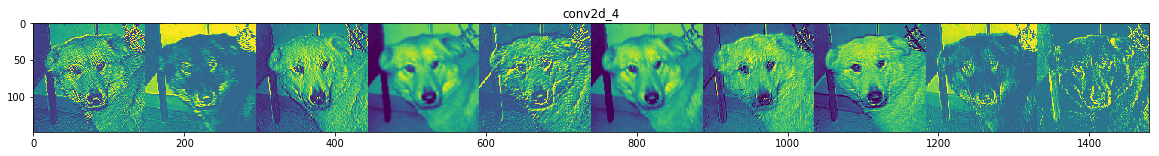

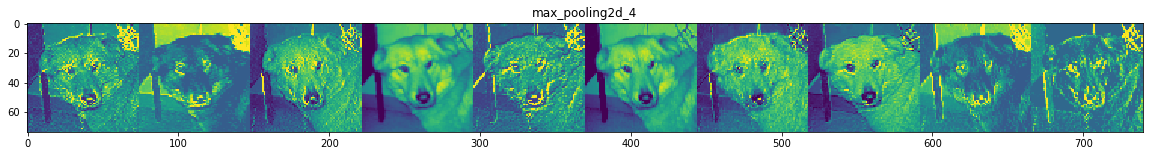

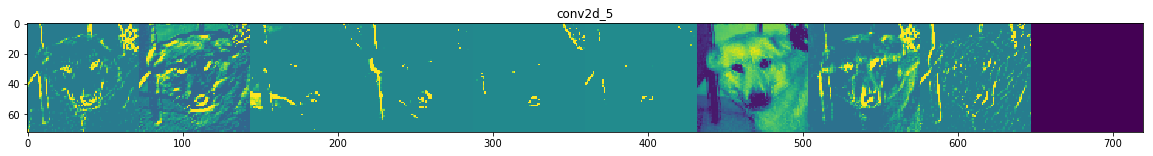

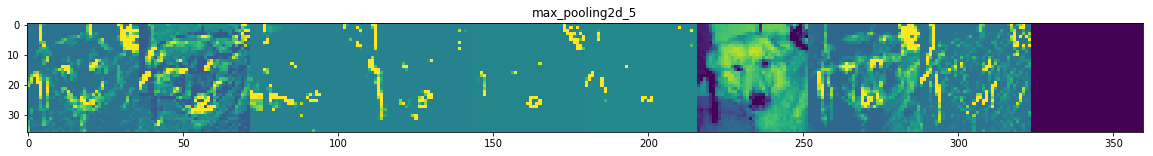

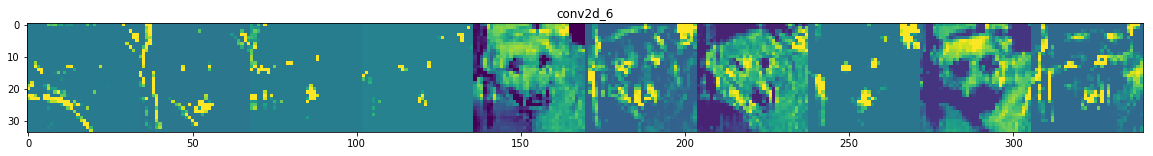

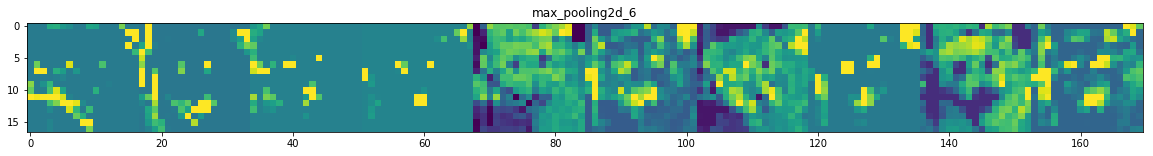

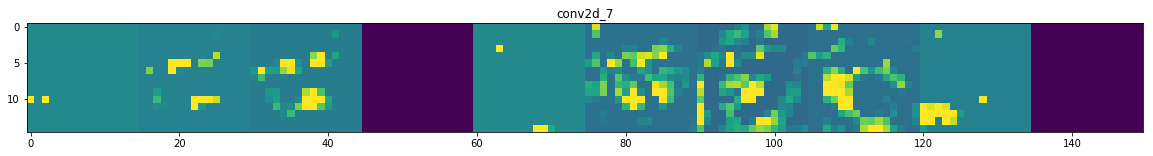

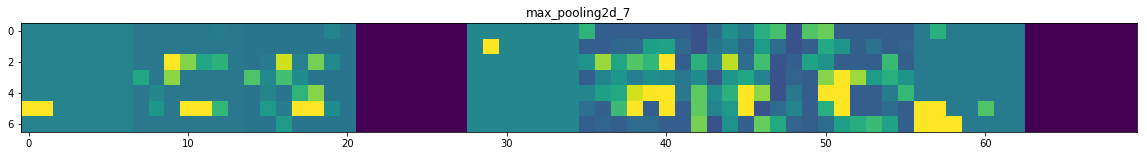

In [8]:
# change n_channels to be plotted

for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:
            n_channels = 10
            size = feature_map.shape[1]
            display_grid = np.zeros((size, size * n_channels))
            for i in range(n_channels):
                    x = feature_map[0, :, :, i]
                    x -= x.mean()
                    x /= x.std()
                    x *= 64
                    x += 128
                    x = np.clip(x, 0, 255).astype('uint8')
                    display_grid[:, i * size : (i + 1) * size] = x
            height = 20. / n_channels 
            plt.figure(figsize = (height * n_channels, height))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.

These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

## 3. Visualizing What the Hidden Units Are Learning

If we want to visualize what the hidden units in different layers are computing, here's what we can do. Let's pick a hidden unit in a specific layer. We scan through our training set and find out what are the image patches that maximize that unit's activation. So in other words, pass our training set through our neural network, and figure out what is the image that maximizes that particular unit's activation. 

We can add the grid lines to the images based on the output shape of the layer. For example, if the layer output shape is (None, w, h, c), we can add w x h grid lines on the image, and we can see what region affects the hidden unit we picked. 

In [9]:
def max_activations(layer, w, h, c, grid = False):
    """
    Plot 10 images that maximize the activation of a specific hidden unit.
    The hidden unit is located at [layer, w, h, c]
    """
    
    outputs = model.layers[layer].output
    layer_size = model.layers[layer].output_shape[1] # the width/height of the output layer
    vis_model1 = Model(inputs = model.input, outputs = outputs)

    # Get the list of paths of all figures 
    train_cat_dir = os.path.join('data/train/cats')
    train_dog_dir = os.path.join('data/train/dogs')
    train_cat_names = os.listdir(train_cat_dir)
    train_dog_names = os.listdir(train_dog_dir)
    train_cat_paths = [os.path.join(train_cat_dir, fname) for fname in train_cat_names]
    train_dog_paths = [os.path.join(train_dog_dir, fname) for fname in train_dog_names]
    paths = train_cat_paths + train_dog_paths

    activations = []
    for i in tqdm(range(len(paths))):
        img = image.load_img(paths[i], target_size = (150, 150))  
        x = image.img_to_array(img) 
        x = x.reshape((1,) + x.shape) 
        x /= 255
        out = vis_model1.predict(x)
        activations.append(out[0][w][h][c])
    # get the indices of maximum activations
    ind = np.argpartition(activations, -16)[-16:]
    
    # plot the results
    nrow = 4
    ncol = 4
    fig, axes = plt.subplots(nrow, ncol)
    fig.suptitle(outputs.name.split('/')[0], fontsize = 20)
    fig.set_size_inches(14, 10)
    for i in range(len(ind)):
        img = image.load_img(paths[ind[i]], target_size = (150, 150))  
        #img = plt.imread(paths[ind[i]])
        row = i // ncol
        col = i % ncol
        axes[row][col].imshow(img)
        if grid == True: 
            # Set minor tick locations and plot the grid lines
            spacing = 150 / layer_size
            minorLocator = MultipleLocator(spacing)
            axes[row][col].yaxis.set_minor_locator(minorLocator)
            axes[row][col].xaxis.set_minor_locator(minorLocator)
            axes[row][col].grid(which = 'minor', linestyle = '-', linewidth = 1, color = 'w')
        else:
            axes[row][col].axis('off')

100%|██████████████████████████████████████| 2000/2000 [00:33<00:00, 60.21it/s]


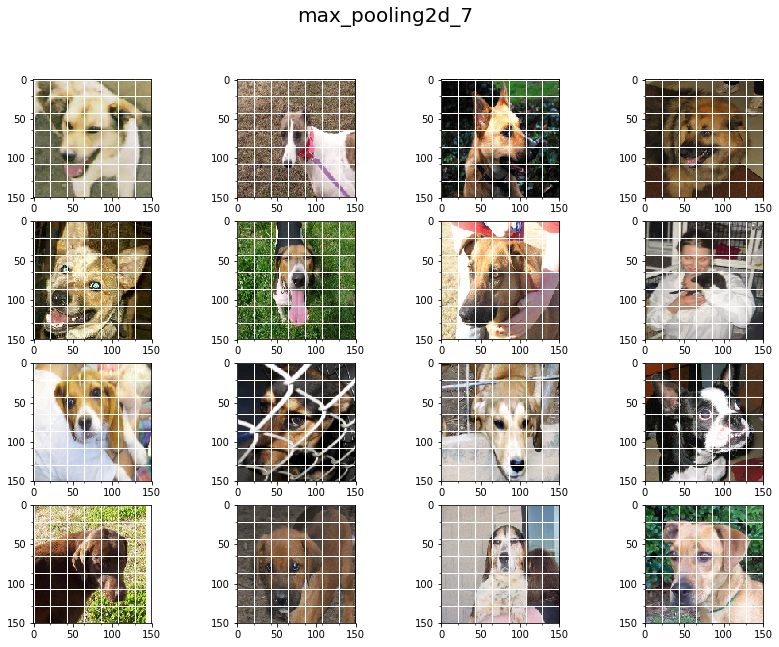

In [10]:
max_activations(7, 3, 3, 2, grid = True)

If we look at the cell located at (3, 3), it seems that this unit is looking for something like noses or eyes. This can also be seen from the previous graph showing intermediate representations: simply examine the 3rd channel of the 8th layer.